In [1]:
import numba
import itertools
import sys
import copy
import numpy as np
try:
    import matplotlib.pyplot as plt
except:
    pass
from typing import *
import logging
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from matplotlib import rc

if sys.platform != "linux":
    rc('animation', ffmpeg_path = 
       r"C:\Users\Jonas\anaconda3\envs\myNumba\Library\bin\ffmpeg.exe")
rc('animation', html='jshtml')

The different bases are represented as a integer, if the sum up to zero, they can bind to each other

In [2]:
Base = int

class Bases:
    A: Base = 1
    G: Base = 2
    C: Base = -2
    T: Base = -1

In [3]:
@numba.experimental.jitclass([
    ("id", numba.int32), 
    ("stickToId", numba.optional(numba.int32)),
    ("stickToPointIdx", numba.optional(numba.int64[:])), 
    ("base", numba.int32), ("coords", numba.float64[:]),
])
class Point:
    id: int
    stickToId: int
    base: Base
    coords: numba.float32[:]

    def __repr__(self):
        return f"(Point id={self.id}, stickToId={self.stickToId}," \
            + f" base={self.base}, coords={self.coords})"

    def __init__(self, id, coords, base):
        self.id = id
        self.stickToId = None
        self.stickToPointIdx = None
        self.base = base
        self.coords = coords

A molecule represents a chain of points or a DNA chain.

In [4]:
@numba.experimental.jitclass([
    ("points", numba.types.ListType(Point.class_type.instance_type))
])
class Molecule:
    # first id from ourselves, second id from other molecule
    points: List[Point]

    def __init__(self, points):
        self.points = points

    def __repr__(self):
        return f"(Molecule {self.points})"

    def ids(self) -> [int]:
        return [point.id for point in self.points]

    def copy(self):
        newPoints = numba.typed.List()
        for point in self.points:
            p = Point(point.id, point.coords.copy(), point.base)
            p.stickToId = point.stickToId

            if point.stickToPointIdx is not None:
                p.stickToPointIdx = point.stickToPointIdx.copy()

            newPoints.append(p)
        return Molecule(newPoints)
                
@numba.extending.overload_method(numba.types.misc.ClassInstanceType, 'reversed')
def ol_molecule_reversed(inst,):
    if inst is Molecule.class_type.instance_type:
        def impl(inst,):
            return Molecule(inst.points[::-1])
        return impl


The next cell contains the implementation of `mutate`, the function that mutates the existing state, for which then the energy is calculated and it gets decided if the new state should be accepted or rejected.

The general idea of `mutate` is to select a random point among the molecule (dna chains), select a direction (up or down) and then rotate the points that come after / before the selected point in the chain by a small angle around the selected point.

If points from different molecules come very close, they can stick together. If a single point in the chain that was initially selected sticks to another point, the complete chain that belongs to that point gets rotated aswell. 
If there are two points, one above and one below the selected point in the chain that stick to other points of the same (but different from the original) chain, the chain the other points belong to get stretched, such that the two pairs of points, that stick together, are again close. 
In cases where this is not possible the mutation gets rejected.

Furthermore there is a random chance for any of the bonded pairs to break.

In [5]:
@numba.njit()
def arccos(angle):
    if angle > 1.0:
        angle = 1.0
    if angle < -1.0:
        angle = -1.0

    try:
        a = np.arccos(angle)
        return a
    except:
        print("bad angle", angle)
        return 0.


@numba.njit()
def mutate(moleculesIn, removeBondProb, rCutoff, angleSigma):
    dont = False

    # search for all bonds
    stickPoints = []
    for molecule in moleculesIn:
        for point in molecule.points:
            if point.stickToId is not None:
                stickPoints.append(point)

    oldNumberOfSticks = len(stickPoints)

    # sticking together stuff
    removeBond = np.random.rand() > 1 - removeBondProb
    if removeBond:
        if len(stickPoints) > 0:
            toDelete = stickPoints[np.random.randint(0, len(stickPoints))]
            otherIdx = toDelete.stickToPointIdx
            other = moleculesIn[otherIdx[0]].points[otherIdx[1]]
            other.stickToId = None
            other.stickToPointIdx = None
            toDelete.stickToId = None
            toDelete.stickToPointIdx = None

    # find rotation point
    moleculeIdx = np.random.randint(0, len(moleculesIn))
    baseIdx = np.random.randint(0, len(moleculesIn[moleculeIdx].points) - 1)

    molecules = moleculesIn

    down = np.random.rand() > 0.5
    if down:
        molecules = numba.typed.List()
        for molecule in moleculesIn:
            molecules.append(molecule.reversed())

    ΔAngle = np.random.randn() * angleSigma

    mainMolecule = molecules[moleculeIdx]
    mainRotationOrigin = mainMolecule.points[baseIdx]
    otherMolecules = [molecule for i, molecule in enumerate(molecules) 
                      if i != moleculeIdx]

    # Rotade main molecule
    rotatePointsAround(mainRotationOrigin, mainMolecule.points[baseIdx + 1:], ΔAngle)

    # Rotated the other molecules that stick to the main one
    for otherMolecule in otherMolecules:
        lowerStickMainPoint, lowerStickIdx = \
            findStickingIdx(mainMolecule.points[0:baseIdx][::-1], otherMolecule.ids())
        upperStickMainPoint, upperStickIdx = \
            findStickingIdx(mainMolecule.points[baseIdx:], otherMolecule.ids())

        if upperStickIdx is None:
            continue
        else:
            rotatePointsAround(mainRotationOrigin, otherMolecule.points, ΔAngle)

            if lowerStickIdx is not None:
                low = min(lowerStickIdx, upperStickIdx) + 1
                high = max(lowerStickIdx, upperStickIdx)

                if low < high:
                    # calculate distance between both sticking points
                    c = lowerStickMainPoint.coords - upperStickMainPoint.coords
                    newDistance = np.linalg.norm(c)

                    # select random point in between
                    adaptionPointIdx = np.random.randint(
                        min(lowerStickIdx, upperStickIdx) + 1,
                        max(lowerStickIdx, upperStickIdx)
                    )
                    adaptionPoint = otherMolecule.points[adaptionPointIdx]
                    a = adaptionPoint.coords - upperStickMainPoint.coords
                    lowerStickOtherIdx = lowerStickMainPoint.stickToPointIdx
                    b = adaptionPoint.coords - \
                        moleculesIn[lowerStickOtherIdx[0]] \
                        .points[lowerStickOtherIdx[1]].coords
                    maximumDistance = np.linalg.norm(a) + np.linalg.norm(b)
                    if maximumDistance < newDistance:
                        newDistance = maximumDistance
                        dont = True

                    # figure out the angle to stretch the otherMolecule 
                    # between the two sticking points to the new distance
                    newcosβ = (np.linalg.norm(a)**2 + np.linalg.norm(b)**2 
                               - newDistance**2) \
                        / (2 * np.linalg.norm(a) * np.linalg.norm(b))
                    newβ = arccos(newcosβ)
                    oldβ = arccos(cosAngleBetween(a, b))
                    adaptionΔAngle = newβ - oldβ

                    clockwiseOldβ = clockwiseAngleBetween(a, b)
                    adaptionΔAngle *= np.sign(clockwiseOldβ)

                    rotatePointsAround(adaptionPoint, 
                                       otherMolecule.points[0:adaptionPointIdx], 
                                       adaptionΔAngle)

                # correct the orientation of the otherMolecule to fit the mainMolecule
                lowerStickIdx = int(lowerStickIdx)
                otherOrientation = otherMolecule.points[lowerStickIdx].coords \
                    - upperStickMainPoint.coords
                mainOrientation = lowerStickMainPoint.coords \
                    - upperStickMainPoint.coords
                orientationΔAngle = arccos(
                    cosAngleBetween(otherOrientation, mainOrientation))
                clockwiseOrientationΔAngle = \
                    clockwiseAngleBetween(otherOrientation, mainOrientation)
                
                upperStickOtherIdx = upperStickMainPoint.stickToPointIdx
                upperStickOtherPoint = \
                    moleculesIn[upperStickOtherIdx[0]].points[upperStickOtherIdx[1]]
                rotatePointsAround(upperStickOtherPoint, 
                                   otherMolecule.points[0:upperStickIdx], 
                                   orientationΔAngle * \
                                   np.sign(clockwiseOrientationΔAngle))


    newNumberOfSticks = 0
    # find the old bonds that got broken due to being moved too far away
    for molecule in molecules:
        for point in molecule.points:
            if point.stickToId is not None:
                otherIdx = point.stickToPointIdx
                other = moleculesIn[otherIdx[0]].points[otherIdx[1]]
                if np.linalg.norm(point.coords - other.coords) > rCutoff:
                    other.stickToId = None
                    other.stickToPointIdx = None
                    point.stickToId = None
                    point.stickToPointIdx = None
                else:
                    newNumberOfSticks += 1

    realNewSticks = 0
    # search for new bonds if the points get close
    for i, moleculeA in enumerate(moleculesIn):
        for j, moleculeB in enumerate(moleculesIn):
            if i == j:
                continue
            for k, pointA in enumerate(moleculeA.points):
                for l, pointB in enumerate(moleculeB.points):
                    if (pointA.base + pointB.base == 0) \
                        and (np.linalg.norm(pointA.coords - pointB.coords) < rCutoff):
                        if pointA.stickToId is None and pointB.stickToId is None:
                            newNumberOfSticks += 2
                            realNewSticks += 1
                            pointA.stickToId = pointB.id
                            pointA.stickToPointIdx = np.array([j, l])
                            pointB.stickToId = pointA.id
                            pointB.stickToPointIdx = np.array([i, k])

    # undo reversing the points to handle rotation 
    # of the lower part instea of the upper part
    if down:
        newMolecules = numba.typed.List()
        for molecule in molecules:
            newMolecules.append(molecule.reversed())
        molecules = newMolecules

    # shift back everything to have the first point of the first molecule at (0, 0)
    origin = molecules[0].points[0].coords
    for molecule in molecules:
        for point in molecule.points:
            point.coords = point.coords - origin

    dont = dont or ((oldNumberOfSticks > newNumberOfSticks) and not removeBond)
    return dont, realNewSticks

@numba.njit()
def clockwiseAngleBetween(a, b) -> float:
    return np.arctan2(a[0] * b[1] - a[1] * b[0], np.dot(a, b))

@numba.njit()
def cosAngleBetween(a, b) -> float:
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

@numba.njit()
def findStickingIdx(mainPoints, otherIds):
    for point in mainPoints:
        try:
            return point, otherIds.index(point.stickToId)
        except:
            pass
    return None, None

@numba.njit()
def rotatePointsAround(origin, points, ΔAngle):
    for point in points:
        point.coords = rotateAround(origin.coords, point.coords, ΔAngle)

@numba.njit()
def rotateAround(origin, point, ΔAngle):
    offset = point - origin
    newOffset = np.zeros_like(offset, dtype=np.float64)
    newOffset[0] =  np.cos(ΔAngle) * offset[0] - np.sin(ΔAngle) * offset[1]
    newOffset[1] =  np.sin(ΔAngle) * offset[0] + np.cos(ΔAngle) * offset[1]
    return origin + newOffset

The energy is made up of two parts, a globally acting force proportional to the distance of points that do not belong to the same chain, which simply exists to pull the molecules together.

The second part is a kind of binding energy, that only acts locally between points that have matching bases (the sum of the base code equals zero). This force has a strict cutoff and the slope is parametrized.

In [6]:
@numba.njit()
def H(molecules, α, β, bindingPower, rCutoff, rCutoffLocalForce):
    H = 0
    for i, moleculeA in enumerate(molecules):
        for point in moleculeA.points:
            if point.stickToId is not None:
                otherIdx = point.stickToPointIdx
                other = molecules[otherIdx[0]].points[otherIdx[1]]
                r = np.linalg.norm(point.coords - other.coords)
                H += β * (r**bindingPower - rCutoff**bindingPower)

        for j, moleculeB in enumerate(molecules):
            if i == j:
                continue
            for pointA in moleculeA.points:
                for pointB in moleculeB.points:
                    if (pointA.base + pointB.base == 0) \
                        and pointA.stickToId is None \
                        and pointB.stickToId is None:
                        r = np.linalg.norm(pointA.coords - pointB.coords)
                        H += α * r

    return H

In [7]:
def plot(self, molecules):
    x = [point.coords[0] for point in self.points]
    y = [point.coords[1] for point in self.points]
    plt.plot(x, y, marker="o")

    label = "sticks to"
    for point in self.points:
        if point.stickToId is not None:
            otherIdx = point.stickToPointIdx
            other = molecules[otherIdx[0]].points[otherIdx[1]]
            label = str(point.id) + "<->" + str(other.id)
            plt.plot([point.coords[0]], 
                     [point.coords[1]], 
                     marker = "x", color = "black", label = label)

def generateMolecules(*packedPositionBases):
    id = 0
    molecules = numba.typed.List()
    for packedPositionBase in packedPositionBases:
        points = numba.typed.List()
        for posBase in packedPositionBase:
            newPoint = Point(id = id, base = posBase[0], coords = posBase[1:])
            points.append(newPoint)
            id += 1
        molecules.append(Molecule(points))

    return molecules

Finally the main loop simply mutates the existing state, calculates the new energy and accepts the new state if the energy is lower, of with a random chance if the energy is higher.

(There are two versions, because we can not return the inbetween steps from the numba version)

In [8]:
@numba.njit()
def run(molecules, α, β, rCutoff, rCutoffLocalForce, 
        bindingPower, angleSigma, removeBondProb, T, N):
    oldH = H(molecules, α=α, β=β, rCutoff=rCutoff, 
             rCutoffLocalForce=rCutoffLocalForce, bindingPower=bindingPower)
    Hs = []
    sticks = []
    
    for i in range(N):
        newMolecules = \
            numba.typed.List([molecule.copy() for molecule in molecules])
        dont, realNewSticks = mutate(newMolecules, rCutoff=rCutoff,
                                     angleSigma=angleSigma, 
                                     removeBondProb=removeBondProb)
        ΔH = H(newMolecules, α=α, β=β, rCutoff=rCutoff, 
               rCutoffLocalForce=rCutoffLocalForce, bindingPower=bindingPower) - oldH
        r = np.random.rand()

        newSticks = 0
        if r < np.minimum(1., np.exp(-ΔH / T)) and not dont:
            molecules = newMolecules
            oldH += ΔH
            newSticks = realNewSticks

        Hs.append(oldH)
        sticks.append(newSticks)
    return (Hs, sticks)

def slow_run(molecules, α, β, rCutoff, rCutoffLocalForce, 
             bindingPower, angleSigma, removeBondProb, T, N):
    oldH = H(molecules, α=α, β=β, rCutoff=rCutoff, 
             rCutoffLocalForce=rCutoffLocalForce, bindingPower=bindingPower)
    Hs = []
    sticks = []
    
    allSteps = []
    
    for i in range(N):
        newMolecules = \
            numba.typed.List([molecule.copy() for molecule in molecules])
        dont, realNewSticks = mutate(newMolecules, rCutoff=rCutoff, 
                                     angleSigma=angleSigma, 
                                     removeBondProb=removeBondProb)
        ΔH = H(newMolecules, α=α, β=β, rCutoff=rCutoff, 
               rCutoffLocalForce=rCutoffLocalForce, bindingPower=bindingPower) - oldH
        r = np.random.rand()

        newSticks = 0
        if r < np.minimum(1., np.exp(-ΔH / T)) and not dont:
            molecules = newMolecules
            oldH += ΔH
            newSticks = realNewSticks
            
                    
        allSteps.append(molecules)

        Hs.append(oldH)
        sticks.append(newSticks)
    return (Hs, sticks, allSteps)

This sets up a simple system of two dna chains, one with 10 elements, one with 5 elements and matching bases, so that each point in the one chain can bind to each point in the other chain.

In [9]:
dimension = 2

baseSpacing = 1
rCutoff = 0.2 #baseSpacing /4
β = 10
bindingPower = 4
rCutoffLocalForce = rCutoff * 4
α = 0.001
T = 1 / 100
angleSigma = 1.0

removeBondProb = 0.1

scaffoldNucleotide = [*([Bases.T] * 10)]
stapleNucleotide = [*([Bases.A] * 5)]

numberOfScaffoldNucleotides = len(scaffoldNucleotide)
numberOfStapleNucleotides = len(stapleNucleotide)
boxSize = 2 * (numberOfScaffoldNucleotides + numberOfStapleNucleotides) * baseSpacing
scaffold = np.zeros((numberOfScaffoldNucleotides, dimension + 1), dtype=np.float64)
staple = np.zeros((numberOfStapleNucleotides, dimension + 1), dtype=np.float64)

for i in range(numberOfScaffoldNucleotides):
    scaffold[i][0] = scaffoldNucleotide[i]
    scaffold[i][1] = -(boxSize / 4) + 4
    scaffold[i][2] = -(boxSize / 4) + baseSpacing * i + 4

for i in range(numberOfStapleNucleotides):
    staple[i][0] = stapleNucleotide[i]
    staple[i][1] = -(boxSize / 4) + baseSpacing * i + 10 + 0.25
    staple[i][2] = +(boxSize / 4) - 3


molecules = generateMolecules(scaffold, staple)

Hs, sticks = run(molecules, α=α, β=β, rCutoff=rCutoff, T=T, N = 10000,
    rCutoffLocalForce=rCutoffLocalForce, bindingPower=bindingPower, 
                 angleSigma=angleSigma, removeBondProb=removeBondProb)

To visualize the system evolution over time, we can plot the two chains and convert the series of plots into an animation.

In [10]:
def animate(steps, step=50):
    fig, ax = plt.subplots()
        
    def xydata(molecule):
        x = [point.coords[0] for point in molecule.points]
        y = [point.coords[1] for point in molecule.points]
        return (x, y)
    
    lines = [plt.plot(*xydata(molecule), marker="o")[0] for molecule in molecules]
    
    def init():
        ax.set_xlim(-boxSize/2, boxSize/2)
        ax.set_ylim(-boxSize/2, boxSize/2)
        return lines

    def update(frame):
        molecules = steps[frame * step]
        for i, molecule in enumerate(molecules):
            lines[i].set_data(*xydata(molecule))

        return lines

    ani = FuncAnimation(fig, update, frames=len(steps) // step, 
                        init_func=init, blit=True)
    plt.close()
    return ani

In [11]:
Hs, sticks, outMolecules = \
    slow_run(molecules, α=α, β=β, rCutoff=rCutoff, 
             T=T, N = 10000, rCutoffLocalForce=rCutoffLocalForce, 
             bindingPower=bindingPower, angleSigma=angleSigma, 
             removeBondProb=removeBondProb)


This shows a example animation for the system setup above

In [12]:
animate(outMolecules)

Finally, we examine the influence of some of the parameters. Here we look a different values for β and T. β controls the strength of the binding force and T is the temperature.

In [13]:
dimension = 2

baseSpacing = 1
rCutoff = 0.2
β = 10
bindingPower = 4
rCutoffLocalForce = rCutoff * 4
α = 0.001
T = 1 / 100
angleSigma = 1.0

removeBondProb = 0.1

scaffoldNucleotide = [*([Bases.T] * 10)]
stapleNucleotide = [*([Bases.A] * 5)]

numberOfScaffoldNucleotides = len(scaffoldNucleotide)
numberOfStapleNucleotides = len(stapleNucleotide)
boxSize = 2 * (numberOfScaffoldNucleotides + 
               numberOfStapleNucleotides) * baseSpacing
scaffold = np.zeros((numberOfScaffoldNucleotides, dimension + 1), dtype=np.float64)
staple = np.zeros((numberOfStapleNucleotides, dimension + 1), dtype=np.float64)

for i in range(numberOfScaffoldNucleotides):
    scaffold[i][0] = scaffoldNucleotide[i]
    scaffold[i][1] = -(boxSize / 4) + 4
    scaffold[i][2] = -(boxSize / 4) + baseSpacing * i + 4

for i in range(numberOfStapleNucleotides):
    staple[i][0] = stapleNucleotide[i]
    staple[i][1] = -(boxSize / 4) + baseSpacing * i + 10 + 0.25
    staple[i][2] = +(boxSize / 4) - 3


molecules = generateMolecules(scaffold, staple)

def getExperimentData():
    temps = np.logspace(1,-5, 10)
    times = 10
    bethas = np.logspace(1, 5, 10)
    plotBethas, plotTemps, plotSticks, plotHs, expNumbers = [], [], [], [], []
    ex = 0 
    for betha in bethas:
        for temp in temps:
            ex += 1
            for i in range(times):
                Hs, sticks = run(molecules, α=α, β=betha, rCutoff=rCutoff, T=temp, 
                                 N = 10000, rCutoffLocalForce=rCutoffLocalForce, 
                                 bindingPower=bindingPower, angleSigma=angleSigma, 
                                 removeBondProb=removeBondProb)
                plotBethas.append( betha )
                plotTemps.append(temp)
                plotSticks.append(sticks)
                plotHs.append(plotHs)
                expNumbers.append(ex)
    return plotBethas, plotTemps, plotSticks, plotHs, expNumbers
            

In [14]:
plotBethas, plotTemps, plotSticks, plotHs, expNumbers = getExperimentData()

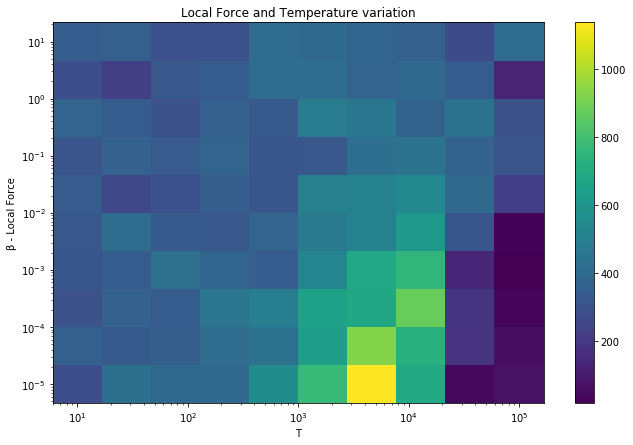

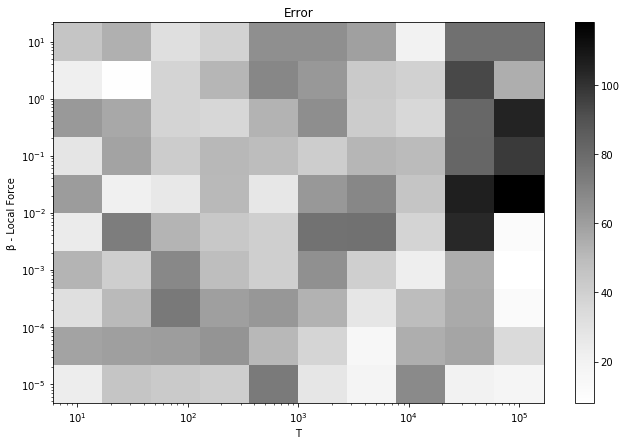

In [15]:
def logGridFromCenters(centers):
    spacing = np.sqrt(centers[1] / centers[0])
    return np.logspace(np.log10(centers[0] / spacing),
                       np.log10(centers[-1] * spacing),
                       len(centers) + 1)

βs = np.sort(np.unique(plotBethas))
Ts = np.sort(np.unique(plotTemps))
plotSticks = np.array(plotSticks)

values = np.empty((len(βs), len(Ts)))
std = np.empty((len(βs), len(Ts)))

for i, β in enumerate(βs):
    for j, T in enumerate(Ts):
        sticks = np.sum(plotSticks[np.where((plotBethas == β) 
                                            & (plotTemps == T))], axis=1)
        values[i,j] = np.mean(sticks)
        std[i,j] = np.std(sticks) / np.sqrt(len(sticks) - 1)

plt.figure(figsize=(11,7))
x, y = np.meshgrid(βs, Ts)



βsgrid = logGridFromCenters(βs)
Tsgrid = logGridFromCenters(Ts)
x, y = np.meshgrid(βsgrid, Tsgrid)

plt.pcolor(x, y, values)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("T")
plt.ylabel("β - Local Force")
plt.title("Local Force and Temperature variation")
plt.colorbar()
plt.show()

plt.figure(figsize=(11,7))

plt.pcolor(x, y, std, cmap="Greys")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("T")
plt.ylabel("β - Local Force")
plt.title("Error")
plt.colorbar()
plt.show()

We can see, as expected, with increasing `T` and decreasing `β`, the number of new bonds formed increases, up to a point, where `T` is so big, that the globally acting force that pulls the chains together is no longer strong enough and the chains no longer get close together.